In [1]:
import torch
import torchvision
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision.models import ResNet18_Weights

# 设备设置
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 数据增强和预处理
train_transform_aug = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.5, 1.0)),  # 随机裁剪并调整大小
    transforms.RandomHorizontalFlip(),  # 随机水平翻转
    transforms.RandomRotation(10),  # 随机旋转
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.05),  # 随机颜色抖动
    transforms.ToTensor(),  # 转换为张量
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # 标准化
])

train_transform_no_aug = transforms.Compose([
    transforms.Resize((224, 224)),  # 调整大小
    transforms.ToTensor(),  # 转换为张量
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # 标准化
])

val_transform = transforms.Compose([
    transforms.Resize(256),  # 调整大小
    transforms.CenterCrop(224),  # 中心裁剪
    transforms.ToTensor(),  # 转换为张量
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # 标准化
])

# 加载数据集
train_data_aug = datasets.ImageFolder('a5_data/train', transform=train_transform_aug)
train_data_no_aug = datasets.ImageFolder('a5_data/train', transform=train_transform_no_aug)
val_data = datasets.ImageFolder('a5_data/val', transform=val_transform)

train_loader_aug = DataLoader(train_data_aug, batch_size=32, shuffle=True)
train_loader_no_aug = DataLoader(train_data_no_aug, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)



In [2]:
# 定义模型
class SimpleCNN(nn.Module):
    def __init__(self, use_bn=False, use_residual=False):
        super(SimpleCNN, self).__init__()
        self.use_residual = use_residual
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(64) if use_bn else nn.Identity()
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(128) if use_bn else nn.Identity()
        self.fc = None  # 动态计算全连接层输入维度

        # 残差连接的1x1卷积
        if use_residual:
            self.residual_conv = nn.Conv2d(3, 128, kernel_size=1, stride=2)

    def forward(self, x):
        residual = x
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.pool(x)  # 224x224 -> 112x112
        x = self.conv2(x)
        x = self.bn2(x)
        if self.use_residual:
            residual = self.residual_conv(residual)  # 调整残差连接的形状
            x += residual
        x = self.relu(x)
        x = x.view(x.size(0), -1)  # 展平

        # 动态计算全连接层的输入维度
        if self.fc is None:
            self.fc = nn.Linear(x.size(1), 2).to(x.device)
        x = self.fc(x)
        return x



In [3]:
# 训练函数
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10, scheduler=None):
    train_losses, val_losses, val_accuracies = [], [], []
    best_val_accuracy = 0.0

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
        train_loss = running_loss / len(train_loader)
        train_losses.append(train_loss)
        
        # 验证集评估
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        val_loss /= len(val_loader)
        val_accuracy = correct / total
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)
        
        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")
        
        # # 保存最佳模型
        # if val_accuracy > best_val_accuracy:
        #     best_val_accuracy = val_accuracy
        #     torch.save(model.state_dict(), 'best_model.pth')
        #     print(f"Saved best model with validation accuracy: {val_accuracy:.4f}")
        
        # # 更新学习率
        # if scheduler is not None:
        #     scheduler.step()
    
    return train_losses, val_losses, val_accuracies



In [4]:
# 对比实验
num_epochs = 50
results = {}

# 基线模型（无归一化、无残差连接、无数据增强）
model = SimpleCNN(use_bn=False, use_residual=False).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.00005)
criterion = nn.CrossEntropyLoss()
train_losses, val_losses, val_accuracies = train_model(model, train_loader_no_aug, val_loader, criterion, optimizer, num_epochs)
results['Baseline'] = {'train_loss': train_losses, 'val_loss': val_losses, 'val_accuracy': val_accuracies}



Epoch 1/50, Train Loss: 0.5602, Val Loss: 0.5292, Val Accuracy: 0.7204
Epoch 2/50, Train Loss: 0.4747, Val Loss: 0.5030, Val Accuracy: 0.7396
Epoch 3/50, Train Loss: 0.4508, Val Loss: 0.4925, Val Accuracy: 0.7452
Epoch 4/50, Train Loss: 0.4386, Val Loss: 0.4869, Val Accuracy: 0.7492
Epoch 5/50, Train Loss: 0.4305, Val Loss: 0.4846, Val Accuracy: 0.7588
Epoch 6/50, Train Loss: 0.4255, Val Loss: 0.4777, Val Accuracy: 0.7596
Epoch 7/50, Train Loss: 0.4212, Val Loss: 0.4733, Val Accuracy: 0.7588
Epoch 8/50, Train Loss: 0.4170, Val Loss: 0.4705, Val Accuracy: 0.7620
Epoch 9/50, Train Loss: 0.4143, Val Loss: 0.4766, Val Accuracy: 0.7468
Epoch 10/50, Train Loss: 0.4116, Val Loss: 0.4671, Val Accuracy: 0.7644
Epoch 11/50, Train Loss: 0.4087, Val Loss: 0.4666, Val Accuracy: 0.7620
Epoch 12/50, Train Loss: 0.4067, Val Loss: 0.4657, Val Accuracy: 0.7628
Epoch 13/50, Train Loss: 0.4043, Val Loss: 0.4647, Val Accuracy: 0.7668
Epoch 14/50, Train Loss: 0.4027, Val Loss: 0.4660, Val Accuracy: 0.7644
E

In [5]:
# 添加批量归一化
model = SimpleCNN(use_bn=True, use_residual=False).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.00005)
train_losses, val_losses, val_accuracies = train_model(model, train_loader_no_aug, val_loader, criterion, optimizer, num_epochs)
results['With BN'] = {'train_loss': train_losses, 'val_loss': val_losses, 'val_accuracy': val_accuracies}



Epoch 1/50, Train Loss: 0.4848, Val Loss: 0.4530, Val Accuracy: 0.7692
Epoch 2/50, Train Loss: 0.4083, Val Loss: 0.4429, Val Accuracy: 0.7812
Epoch 3/50, Train Loss: 0.3946, Val Loss: 0.4319, Val Accuracy: 0.7907
Epoch 4/50, Train Loss: 0.3835, Val Loss: 0.4341, Val Accuracy: 0.7955
Epoch 5/50, Train Loss: 0.3778, Val Loss: 0.4279, Val Accuracy: 0.7939
Epoch 6/50, Train Loss: 0.3710, Val Loss: 0.4257, Val Accuracy: 0.7867
Epoch 7/50, Train Loss: 0.3677, Val Loss: 0.4244, Val Accuracy: 0.7939
Epoch 8/50, Train Loss: 0.3599, Val Loss: 0.4214, Val Accuracy: 0.7923
Epoch 9/50, Train Loss: 0.3577, Val Loss: 0.4181, Val Accuracy: 0.7859
Epoch 10/50, Train Loss: 0.3533, Val Loss: 0.4155, Val Accuracy: 0.7971
Epoch 11/50, Train Loss: 0.3503, Val Loss: 0.4171, Val Accuracy: 0.7963
Epoch 12/50, Train Loss: 0.3469, Val Loss: 0.4122, Val Accuracy: 0.7931
Epoch 13/50, Train Loss: 0.3436, Val Loss: 0.4184, Val Accuracy: 0.7939
Epoch 14/50, Train Loss: 0.3435, Val Loss: 0.4154, Val Accuracy: 0.7971
E

In [6]:
# 添加残差连接
model = SimpleCNN(use_bn=False, use_residual=True).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.00005)
train_losses, val_losses, val_accuracies = train_model(model, train_loader_no_aug, val_loader, criterion, optimizer, num_epochs)
results['With Residual'] = {'train_loss': train_losses, 'val_loss': val_losses, 'val_accuracy': val_accuracies}



Epoch 1/50, Train Loss: 0.5408, Val Loss: 0.5152, Val Accuracy: 0.7157
Epoch 2/50, Train Loss: 0.4640, Val Loss: 0.4899, Val Accuracy: 0.7396
Epoch 3/50, Train Loss: 0.4453, Val Loss: 0.4791, Val Accuracy: 0.7548
Epoch 4/50, Train Loss: 0.4355, Val Loss: 0.4739, Val Accuracy: 0.7596
Epoch 5/50, Train Loss: 0.4285, Val Loss: 0.4686, Val Accuracy: 0.7636
Epoch 6/50, Train Loss: 0.4242, Val Loss: 0.4641, Val Accuracy: 0.7708
Epoch 7/50, Train Loss: 0.4208, Val Loss: 0.4631, Val Accuracy: 0.7652
Epoch 8/50, Train Loss: 0.4174, Val Loss: 0.4637, Val Accuracy: 0.7660
Epoch 9/50, Train Loss: 0.4147, Val Loss: 0.4608, Val Accuracy: 0.7716
Epoch 10/50, Train Loss: 0.4125, Val Loss: 0.4603, Val Accuracy: 0.7724
Epoch 11/50, Train Loss: 0.4104, Val Loss: 0.4579, Val Accuracy: 0.7764
Epoch 12/50, Train Loss: 0.4079, Val Loss: 0.4569, Val Accuracy: 0.7764
Epoch 13/50, Train Loss: 0.4058, Val Loss: 0.4550, Val Accuracy: 0.7732
Epoch 14/50, Train Loss: 0.4044, Val Loss: 0.4545, Val Accuracy: 0.7764
E

In [7]:
# 添加数据增强
model = SimpleCNN(use_bn=False, use_residual=False).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.00005)
train_losses, val_losses, val_accuracies = train_model(model, train_loader_aug, val_loader, criterion, optimizer, num_epochs)
results['With Data Augmentation'] = {'train_loss': train_losses, 'val_loss': val_losses, 'val_accuracy': val_accuracies}



Epoch 1/50, Train Loss: 0.6133, Val Loss: 0.5582, Val Accuracy: 0.6573
Epoch 2/50, Train Loss: 0.5409, Val Loss: 0.5423, Val Accuracy: 0.6701
Epoch 3/50, Train Loss: 0.5199, Val Loss: 0.5220, Val Accuracy: 0.6909
Epoch 4/50, Train Loss: 0.5128, Val Loss: 0.5169, Val Accuracy: 0.6973
Epoch 5/50, Train Loss: 0.5041, Val Loss: 0.5230, Val Accuracy: 0.6941
Epoch 6/50, Train Loss: 0.4958, Val Loss: 0.5100, Val Accuracy: 0.7077
Epoch 7/50, Train Loss: 0.4958, Val Loss: 0.5195, Val Accuracy: 0.6973
Epoch 8/50, Train Loss: 0.4923, Val Loss: 0.4933, Val Accuracy: 0.7292
Epoch 9/50, Train Loss: 0.4882, Val Loss: 0.5024, Val Accuracy: 0.7125
Epoch 10/50, Train Loss: 0.4900, Val Loss: 0.4949, Val Accuracy: 0.7252
Epoch 11/50, Train Loss: 0.4881, Val Loss: 0.4879, Val Accuracy: 0.7300
Epoch 12/50, Train Loss: 0.4809, Val Loss: 0.5018, Val Accuracy: 0.7228
Epoch 13/50, Train Loss: 0.4800, Val Loss: 0.4982, Val Accuracy: 0.7276
Epoch 14/50, Train Loss: 0.4819, Val Loss: 0.4988, Val Accuracy: 0.7292
E

In [8]:
# 添加迁移学习（使用预训练的 ResNet18）
model = torchvision.models.resnet18(weights=ResNet18_Weights.DEFAULT)
for param in model.parameters():
    param.requires_grad = False
model.fc = nn.Linear(model.fc.in_features, 2)
model = model.to(device)
optimizer = optim.Adam(model.fc.parameters(), lr=0.00005)
train_losses, val_losses, val_accuracies = train_model(model, train_loader_no_aug, val_loader, criterion, optimizer, num_epochs)
results['With Transfer Learning'] = {'train_loss': train_losses, 'val_loss': val_losses, 'val_accuracy': val_accuracies}



Epoch 1/50, Train Loss: 0.6876, Val Loss: 0.6064, Val Accuracy: 0.6605
Epoch 2/50, Train Loss: 0.5619, Val Loss: 0.5256, Val Accuracy: 0.7284
Epoch 3/50, Train Loss: 0.5006, Val Loss: 0.4821, Val Accuracy: 0.7644
Epoch 4/50, Train Loss: 0.4669, Val Loss: 0.4558, Val Accuracy: 0.7700
Epoch 5/50, Train Loss: 0.4451, Val Loss: 0.4456, Val Accuracy: 0.7796
Epoch 6/50, Train Loss: 0.4322, Val Loss: 0.4258, Val Accuracy: 0.7979
Epoch 7/50, Train Loss: 0.4164, Val Loss: 0.4179, Val Accuracy: 0.7987
Epoch 8/50, Train Loss: 0.4055, Val Loss: 0.4052, Val Accuracy: 0.8035
Epoch 9/50, Train Loss: 0.4017, Val Loss: 0.4111, Val Accuracy: 0.8107
Epoch 10/50, Train Loss: 0.3929, Val Loss: 0.3926, Val Accuracy: 0.8115
Epoch 11/50, Train Loss: 0.3902, Val Loss: 0.3908, Val Accuracy: 0.8195
Epoch 12/50, Train Loss: 0.3830, Val Loss: 0.3891, Val Accuracy: 0.8195
Epoch 13/50, Train Loss: 0.3801, Val Loss: 0.3847, Val Accuracy: 0.8211
Epoch 14/50, Train Loss: 0.3702, Val Loss: 0.3882, Val Accuracy: 0.8163
E

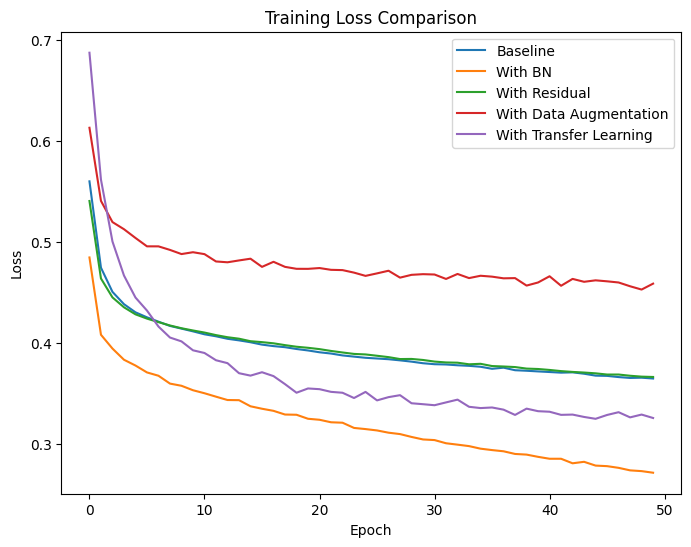

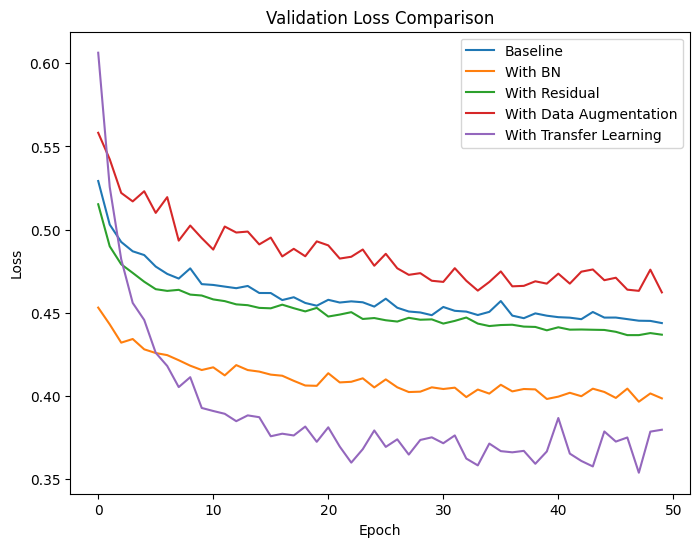

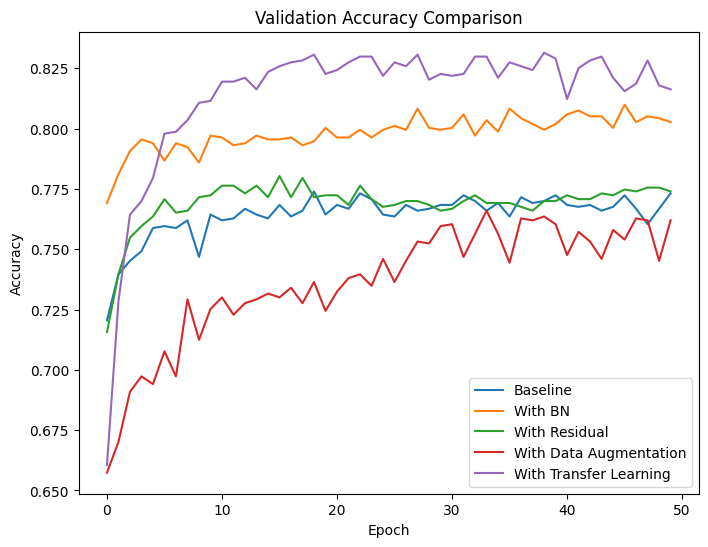

In [9]:
# 绘制训练损失对比
plt.figure(figsize=(8, 6))
for label, data in results.items():
    plt.plot(data['train_loss'], label=label)
plt.title('Training Loss Comparison')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# 绘制验证损失对比
plt.figure(figsize=(8, 6))
for label, data in results.items():
    plt.plot(data['val_loss'], label=label)
plt.title('Validation Loss Comparison')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# 绘制验证准确率对比
plt.figure(figsize=(8, 6))
for label, data in results.items():
    plt.plot(data['val_accuracy'], label=label)
plt.title('Validation Accuracy Comparison')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()